**Nombre:** Aaròn Yumancela - **Ejercicio 1:** Introducción a Recuperación de Información

**Objetivo de la práctica**
* Entender el problema de buscar información en colecciones de texto.
* Comprender por qué se necesita un índice invertido en recuperación de información.
* Evaluar la mejora en tiempos de búsqueda cuando usamos estructuras adecuadas.

**Parte 1**

In [6]:
import pandas as pd 
import time
import os
import kagglehub

# Configuración para mostrar todas las filas del DataFrame en el notebook
# Si el número de resultados es muy alto (ej. 1657), esto garantiza verlos todos.
pd.set_option('display.max_rows', None)

# --- Carga de datos del corpus pequeño (IMDb) ---

try:
    path = kagglehub.dataset_download("lakshmi25npathi/imdb-dataset-of-50k-movie-reviews")
    ruta_csv = os.path.join(path, 'IMDB Dataset.csv')
except Exception:
    # Usar la ruta de Kaggle por defecto si la descarga falla
    ruta_csv = '/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv'

df = pd.read_csv(ruta_csv)
print(f"IMDb Reviews cargadas. Total: {len(df)}")


# --- Función: Búsqueda Lineal (Parte 1) ---

def buscar_lineal(df: pd.DataFrame, query: str):
    """ Busca la palabra recorriendo el DF review por review (lento). """
    
    query_lower = query.lower()
    t_inicio = time.time()
    
    # Aplicar la condición directamente para obtener la máscara
    coincidencias = df['review'].apply(
        lambda texto: query_lower in str(texto).lower()
    )
    
    resultados = df[coincidencias]
    tiempo_total = time.time() - t_inicio
    
    print("\n" + "="*40)
    print(f"BÚSQUEDA LINEAL: '{query}'")
    print(f"Docs encontrados: {len(resultados)}")
    print(f"Tiempo: {tiempo_total:.4f}s")
    print("="*40)
    
    return resultados, tiempo_total

# --- Ejecución de Prueba (El cambio clave está aquí) ---

palabra_test = 'wonderful'
df_resultados_lineal, tiempo_lineal = buscar_lineal(df, palabra_test)

print(f"\nMostrando todos los {len(df_resultados_lineal)} resultados para '{palabra_test}':")

# Simplemente dejamos la variable del DataFrame al final de la celda.
# ¡Esto le dice al notebook que muestre el DataFrame completo como tabla!
df_resultados_lineal

IMDb Reviews cargadas. Total: 50000

BÚSQUEDA LINEAL: 'wonderful'
Docs encontrados: 3249
Tiempo: 0.1520s

Mostrando todos los 3249 resultados para 'wonderful':


,review,sentiment
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
29,'War movie' is a Hollywood genre that has been...,positive
41,"This movie is based on the book, ""A Many Splen...",positive
59,"I just watched The Dresser this evening, havin...",positive
72,I thought that Mukhsin has been wonderfully wr...,positive
93,If anyone is wondering why no one makes movies...,positive
105,Marion Davies stars in this remarkable comedy ...,positive
114,The Assignment is an outstanding thriller with...,positive
121,"Ingrid Bergman, playing dentist Walter Matthau...",positive


**Parte 2**

In [2]:
import string
from collections import defaultdict

# --- Funciones de Preprocesamiento y Construcción del Índice ---

def limpiar_tokenizar(texto):
    """ Limpia el texto (minúsculas, sin puntuación) y lo divide en palabras. """
    texto = str(texto).lower()
    texto = texto.translate(str.maketrans('', '', string.punctuation))
    return texto.split()

def crear_indice_invertido(df: pd.DataFrame, col_texto: str):
    """ Crea el índice {palabra: [lista de IDs de documentos]}. """
    print(f"\nCreando índice para {len(df)} documentos...")
    indice = defaultdict(list)
    
    for doc_id, review in df[col_texto].items():
        for token in limpiar_tokenizar(review):
            # Agregar el ID solo si no es el último ID agregado (para evitar duplicados por reseña)
            if not indice[token] or indice[token][-1] != doc_id:
                 indice[token].append(doc_id)
            
    print("Índice listo.")
    return dict(indice)


# --- Búsqueda con el Índice ---

def buscar_con_indice(indice: dict, query: str, df_maestro: pd.DataFrame):
    """ Busca usando el índice (consulta rápida O(1) + filtro de DF). """
    
    t_inicio = time.time()
    
    # El token de búsqueda debe estar limpio
    query_token = limpiar_tokenizar(query)[0] if limpiar_tokenizar(query) else ""
    
    # 1. Consulta el diccionario
    doc_ids = indice.get(query_token, [])
    
    # 2. Filtra el DataFrame original
    resultados = df_maestro.loc[doc_ids]
    
    tiempo_total = time.time() - t_inicio
    
    print("\n" + "="*40)
    print(f"BÚSQUEDA CON ÍNDICE: '{query}'")
    print(f"Docs encontrados: {len(resultados)}")
    print(f"Tiempo: {tiempo_total:.6f}s")
    print("="*40)
    
    return resultados, tiempo_total

# Construir el índice del corpus pequeño
indice_pequeño = crear_indice_invertido(df, 'review')

# Ejecución de prueba
palabra_indice_test = 'excellent'
df_resultados_indice, tiempo_indice = buscar_con_indice(indice_pequeño, palabra_indice_test, df)

if not df_resultados_indice.empty:
    print(f"Primer resultado (Índice {df_resultados_indice.index[0]}):")
    print(df_resultados_indice.iloc[0]['review'][:200] + "...")


Creando índice para 50000 documentos...
Índice listo.

BÚSQUEDA CON ÍNDICE: 'excellent'
Docs encontrados: 3483
Tiempo: 0.002784s
Primer resultado (Índice 16):
Some films just simply should not be remade. This is one of them. In and of itself it is not a bad film. But it fails to capture the flavor and the terror of the 1963 film of the same title. Liam Nees...



--- Cargando Corpus Grande (Rotten Tomatoes) ---
Corpus Grande cargado. Total: 1444963 documentos.

Creando índice para 1444963 documentos...
Índice listo.

*** COMPARANDO TIEMPOS EN CORPUS PEQUEÑO ***

BÚSQUEDA LINEAL: 'movie'
Docs encontrados: 32461
Tiempo: 0.1442s

BÚSQUEDA CON ÍNDICE: 'movie'
Docs encontrados: 29931
Tiempo: 0.004150s

BÚSQUEDA LINEAL: 'bad'
Docs encontrados: 12704
Tiempo: 0.1445s

BÚSQUEDA CON ÍNDICE: 'bad'
Docs encontrados: 11449
Tiempo: 0.002552s

BÚSQUEDA LINEAL: 'excellent'
Docs encontrados: 3625
Tiempo: 0.1476s

BÚSQUEDA CON ÍNDICE: 'excellent'
Docs encontrados: 3483
Tiempo: 0.001025s

BÚSQUEDA LINEAL: 'nonsense'
Docs encontrados: 546
Tiempo: 0.1508s

BÚSQUEDA CON ÍNDICE: 'nonsense'
Docs encontrados: 475
Tiempo: 0.000445s

BÚSQUEDA LINEAL: 'holographic'
Docs encontrados: 7
Tiempo: 0.1451s

BÚSQUEDA CON ÍNDICE: 'holographic'
Docs encontrados: 7
Tiempo: 0.000350s

--- TABLA DE RESULTADOS: CORPUS PEQUEÑO ---
| Palabra     |   Lineal (s) |   Índice (s) |   Mejora

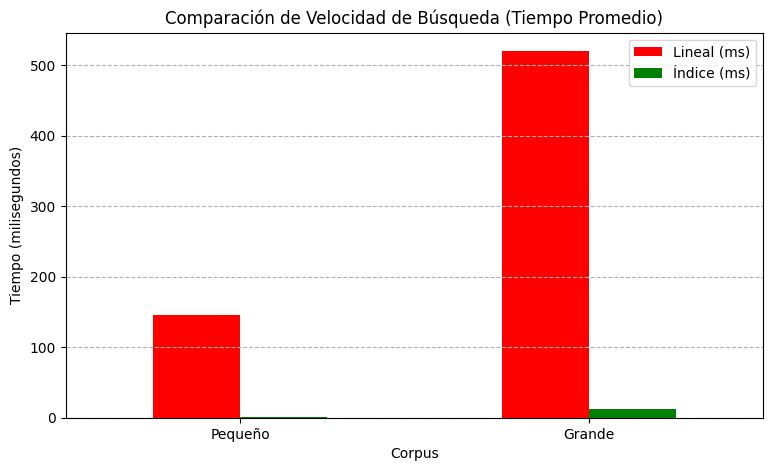

In [8]:
import matplotlib.pyplot as plt

# --- Carga y preparación del Corpus Grande (Rotten Tomatoes) ---

print("\n--- Cargando Corpus Grande (Rotten Tomatoes) ---")
try:
    path_large = kagglehub.dataset_download("andrezaza/clapper-massive-rotten-tomatoes-movies-and-reviews")
    ruta_csv_large = os.path.join(path_large, 'rotten_tomatoes_movie_reviews.csv')
    df_large = pd.read_csv(ruta_csv_large)
    
    # Renombrar columna para que coincida con las funciones
    df_large = df_large.rename(columns={'reviewText': 'review'}) 
    print(f"Corpus Grande cargado. Total: {len(df_large)} documentos.")
    
    # Crear índice para el corpus grande
    indice_grande = crear_indice_invertido(df_large, 'review')
    corpus_grande_disponible = True
except Exception as e:
    print(f"No se pudo cargar el Corpus Grande. Razón: {e}")
    corpus_grande_disponible = False


# --- Evaluación y Comparación ---

def comparar_tiempos(df_corpus, indice, es_grande=False):
    """ Ejecuta y mide ambas búsquedas para varias palabras. """
    
    nombre = "GRANDE" if es_grande else "PEQUEÑO"
    print(f"\n*** COMPARANDO TIEMPOS EN CORPUS {nombre} ***")
    
    palabras = ['movie', 'bad', 'excellent', 'nonsense', 'holographic']
    
    tiempos_data = []
    
    for palabra in palabras:
        # Medición Lineal
        _, t_lineal = buscar_lineal(df_corpus, palabra)
        
        # Medición con Índice
        _, t_indice = buscar_con_indice(indice, palabra, df_corpus)
        
        mejora = t_lineal / t_indice if t_indice > 0 else 0
        
        tiempos_data.append({
            'Palabra': palabra,
            'Lineal (s)': t_lineal,
            'Índice (s)': t_indice,
            'Mejora (x)': mejora
        })
        
    return pd.DataFrame(tiempos_data)


# 1. Evaluar Corpus PEQUEÑO
df_tiempos_pequeño = comparar_tiempos(df, indice_pequeño, es_grande=False)
print("\n--- TABLA DE RESULTADOS: CORPUS PEQUEÑO ---")
print(df_tiempos_pequeño.to_markdown(index=False, floatfmt=".6f"))


# 2. Evaluar Corpus GRANDE
if corpus_grande_disponible:
    df_tiempos_grande = comparar_tiempos(df_large, indice_grande, es_grande=True)
    print("\n--- TABLA DE RESULTADOS: CORPUS GRANDE ---")
    print(df_tiempos_grande.to_markdown(index=False, floatfmt=".6f"))

    # 3. Graficar la mejora
    df_plot = pd.DataFrame({
        'Corpus': ['Pequeño', 'Grande'],
        'Lineal (ms)': [
            df_tiempos_pequeño['Lineal (s)'].mean() * 1000,
            df_tiempos_grande['Lineal (s)'].mean() * 1000,
        ],
        'Índice (ms)': [
            df_tiempos_pequeño['Índice (s)'].mean() * 1000,
            df_tiempos_grande['Índice (s)'].mean() * 1000,
        ]
    }).set_index('Corpus').plot(kind='bar', figsize=(9, 5), color=['red', 'green'])
    
    plt.title('Comparación de Velocidad de Búsqueda (Tiempo Promedio)')
    plt.ylabel('Tiempo (milisegundos)')
    plt.xticks(rotation=0)
    plt.grid(axis='y', linestyle='--')
    plt.show()